In [1]:
import cv2
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
import cv2
vidcap = cv2.VideoCapture('/workspace/test_vid/VID_20191228_133628.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/workspace/test_vid/Frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [ ]:
loc_img="/workspace/test_img"
# len(os.listdir(loc_img))
os.listdir(loc_img)

In [2]:
class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(loc_img))

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,os.listdir(loc_img)[idx])
        image = (Image.open(img_name))

        sample1={'image': image}

        if self.transform:  sample1 = self.transform({'image': image})
        return sample1

0 (1920, 1080)
1 (1920, 1080)
2 (1920, 1080)


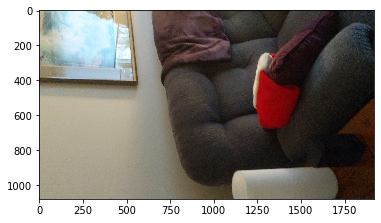

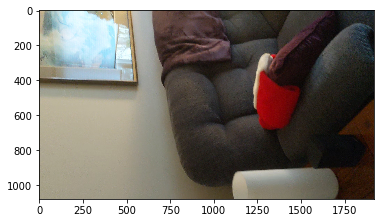

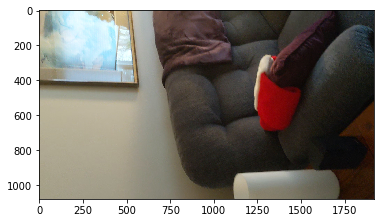

<Figure size 432x288 with 0 Axes>

In [3]:
loc_img='/workspace/test_vid/Frames/'
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size)


    plt.imshow(sample['image'])
    plt.figure()


    if i == 2:
        plt.show()
        break

In [4]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image= sample['image']
        
        image = image.resize((640, 480))
        image = self.to_tensor(image)

        return {'image': image}

    def to_tensor(self, pic):
        pic = np.array(pic)
        if not (_is_numpy_image(pic) or _is_pil_image(pic)):
                raise TypeError(  'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
                
#         if not(_is_pil_image(pic)): 
#             raise TypeError(
#                 'pic should be PIL Image . Got {}'.format(type(pic)))        
               
        if isinstance(pic, np.ndarray):
            if pic.ndim==2:
                pic=pic[..., np.newaxis]
                
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)


In [5]:
depth_dataset = DepthDataset(root_dir=loc_img,
                transform=transforms.Compose([ToTensor()]))
depth_dataset

In [6]:
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
train_loader

In [7]:
dataiter = iter(train_loader)
images = dataiter.next()


In [9]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
from model_dense import Model
model = Model().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/workspace/3.pth'))
model.eval()


DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): DenseNet(
        (features): Sequential(
          (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu0): ReLU(inplace)
          (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (denseblock1): _DenseBlock(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace)
              (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu2): ReLU(inplace)
              (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [54]:
import matplotlib.cm as cm
for i,sample_batched1  in enumerate (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    x=outtt.detach().cpu().numpy()
    x.shape
    x=x.reshape(120,160)
    img=x
    scale_percent = 220 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    plt.imsave('/workspace/test_vid/depth_frames/geeks%d.jpg' %i, resized, cmap='inferno')
#     x.save("/workspace/test_vid/depth_frames/geeks%d.jpg" %i) 
#     plt.imshow(x)
    
#     break

In [55]:
import cv2
import numpy as np
import os
 
from os.path import isfile, join
 
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
    #for sorting the file names properly
    files.sort(key = lambda x: int(x[5:-4]))
 
    for i in range(len(files)):
        filename=pathIn + files[i]
        #reading each files
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        #inserting the frames into an image array
        frame_array.append(img)
 
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
 
def main():
    pathIn= '/workspace/test_vid/depth_frames/'
    pathOut = '/workspace/test_vid/video.avi'
    fps = 25.0
    convert_frames_to_video(pathIn, pathOut, fps)
 
if __name__=="__main__":
    main()

/workspace/test_vid/depth_frames/geeks0.jpg
/workspace/test_vid/depth_frames/geeks1.jpg
/workspace/test_vid/depth_frames/geeks2.jpg
/workspace/test_vid/depth_frames/geeks3.jpg
/workspace/test_vid/depth_frames/geeks4.jpg
/workspace/test_vid/depth_frames/geeks5.jpg
/workspace/test_vid/depth_frames/geeks6.jpg
/workspace/test_vid/depth_frames/geeks7.jpg
/workspace/test_vid/depth_frames/geeks8.jpg
/workspace/test_vid/depth_frames/geeks9.jpg
/workspace/test_vid/depth_frames/geeks10.jpg
/workspace/test_vid/depth_frames/geeks11.jpg
/workspace/test_vid/depth_frames/geeks12.jpg
/workspace/test_vid/depth_frames/geeks13.jpg
/workspace/test_vid/depth_frames/geeks14.jpg
/workspace/test_vid/depth_frames/geeks15.jpg
/workspace/test_vid/depth_frames/geeks16.jpg
/workspace/test_vid/depth_frames/geeks17.jpg
/workspace/test_vid/depth_frames/geeks18.jpg
/workspace/test_vid/depth_frames/geeks19.jpg
/workspace/test_vid/depth_frames/geeks20.jpg
/workspace/test_vid/depth_frames/geeks21.jpg
/workspace/test_vid/

In [56]:
import imageio
import os
 
filenames='/workspace/test_vid/depth_frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]

files.sort(key = lambda x: int(float(x[5:-4])))
files
images = []
for filename in files:
    print(filename)
    images.append(imageio.imread(os.path.join('/workspace/test_vid/depth_frames/',filename)))
    print(filename)
imageio.mimsave('/workspace/test_vid/movie.gif', images)

geeks0.jpg
geeks0.jpg
geeks1.jpg
geeks1.jpg
geeks2.jpg
geeks2.jpg
geeks3.jpg
geeks3.jpg
geeks4.jpg
geeks4.jpg
geeks5.jpg
geeks5.jpg
geeks6.jpg
geeks6.jpg
geeks7.jpg
geeks7.jpg
geeks8.jpg
geeks8.jpg
geeks9.jpg
geeks9.jpg
geeks10.jpg
geeks10.jpg
geeks11.jpg
geeks11.jpg
geeks12.jpg
geeks12.jpg
geeks13.jpg
geeks13.jpg
geeks14.jpg
geeks14.jpg
geeks15.jpg
geeks15.jpg
geeks16.jpg
geeks16.jpg
geeks17.jpg
geeks17.jpg
geeks18.jpg
geeks18.jpg
geeks19.jpg
geeks19.jpg
geeks20.jpg
geeks20.jpg
geeks21.jpg
geeks21.jpg
geeks22.jpg
geeks22.jpg
geeks23.jpg
geeks23.jpg
geeks24.jpg
geeks24.jpg
geeks25.jpg
geeks25.jpg
geeks26.jpg
geeks26.jpg
geeks27.jpg
geeks27.jpg
geeks28.jpg
geeks28.jpg
geeks29.jpg
geeks29.jpg
geeks30.jpg
geeks30.jpg
geeks31.jpg
geeks31.jpg
geeks32.jpg
geeks32.jpg
geeks33.jpg
geeks33.jpg
geeks34.jpg
geeks34.jpg
geeks35.jpg
geeks35.jpg
geeks36.jpg
geeks36.jpg
geeks37.jpg
geeks37.jpg
geeks38.jpg
geeks38.jpg
geeks39.jpg
geeks39.jpg
geeks40.jpg
geeks40.jpg
geeks41.jpg
geeks41.jpg
geeks42.jpg


In [23]:
pip install imageio

    100% |████████████████████████████████| 3.3MB 7.1MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from os.path import isfile, join
filenames='C:/Users/alins/OneDrive/Documents/MENG/Project/Depth Estimation/test_vid/Frames/'
files = [f for f in os.listdir(filenames) if isfile(join(filenames, f))]
files.sort(key = lambda x: int(x[5:-4]))
files

['frame0.jpg',
 'frame1.jpg',
 'frame2.jpg',
 'frame3.jpg',
 'frame4.jpg',
 'frame5.jpg',
 'frame6.jpg',
 'frame7.jpg',
 'frame8.jpg',
 'frame9.jpg',
 'frame10.jpg',
 'frame11.jpg',
 'frame12.jpg',
 'frame13.jpg',
 'frame14.jpg',
 'frame15.jpg',
 'frame16.jpg',
 'frame17.jpg',
 'frame18.jpg',
 'frame19.jpg',
 'frame20.jpg',
 'frame21.jpg',
 'frame22.jpg',
 'frame23.jpg',
 'frame24.jpg',
 'frame25.jpg',
 'frame26.jpg',
 'frame27.jpg',
 'frame28.jpg',
 'frame29.jpg',
 'frame30.jpg',
 'frame31.jpg',
 'frame32.jpg',
 'frame33.jpg',
 'frame34.jpg',
 'frame35.jpg',
 'frame36.jpg',
 'frame37.jpg',
 'frame38.jpg',
 'frame39.jpg',
 'frame40.jpg',
 'frame41.jpg',
 'frame42.jpg',
 'frame43.jpg',
 'frame44.jpg',
 'frame45.jpg',
 'frame46.jpg',
 'frame47.jpg',
 'frame48.jpg',
 'frame49.jpg',
 'frame50.jpg',
 'frame51.jpg',
 'frame52.jpg',
 'frame53.jpg',
 'frame54.jpg',
 'frame55.jpg',
 'frame56.jpg',
 'frame57.jpg',
 'frame58.jpg',
 'frame59.jpg',
 'frame60.jpg',
 'frame61.jpg',
 'frame62.jpg',
 '